In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
np.set_printoptions(precision=5, linewidth=120)
from tqdm import *
from drift_qec.A import *

/Users/yan/.miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [25]:
D = 0.25*np.pi
TIME = 2000
N_TRIALS = 100
RECORDS = []
n = 10

for trial in tqdm(range(N_TRIALS)):
    channel = Channel(kx=0.99998, ky=0.00001, kz=0.00001, Q=FIXEDQ,
                      n=n, d1=D, d2=D, d3=D, stacklength=2001,
                      Vdecayfn = lambda V, t: V / np.sqrt(t))
    for t in range(TIME):
        Anew = channel.update()
        pxhat, pyhat, pzhat = np.real(np.linalg.eig(channel.M)[0])
        Qhat, phat = np.linalg.svd(channel.M)[0:2]
        maxidx = np.argmax(phat)
        W1 = np.sum(channel.V[0:2, 0:2])
        W2 = np.sum(channel.V[0:3:2, 0:3:2])
        W3 = np.sum(channel.V[1:3, 1:3])
        E1 = np.max([np.abs(pxhat - pyhat), 0.01])
        E2 = np.max([np.abs(pxhat - pzhat), 0.01])
        E3 = np.max([np.abs(pyhat - pzhat), 0.01])
        RECORDS.append({
                "t": n*t,
                "d1": channel.d1,
                "d2": channel.d2,
                "d3": channel.d3,
                "|V|": np.sum(channel.V),
                "C_M_Fro":  np.linalg.norm(channel.C - channel.M),
                "q_qhat_2": np.linalg.norm(channel.Q[:, 0] - Qhat[:, 0]),
                "pxhat": pxhat, "pyhat": pyhat, "pzhat": pzhat,
                "W1": W1, "W2": W2, "W3": W3,
                "E1": E1, "E2": E2, "E3": E3,
                "|Anew|": np.sum(Anew)
            })

df = pd.DataFrame(RECORDS)
df.to_csv("CorrectlyFadingDelta10x2000.csv")

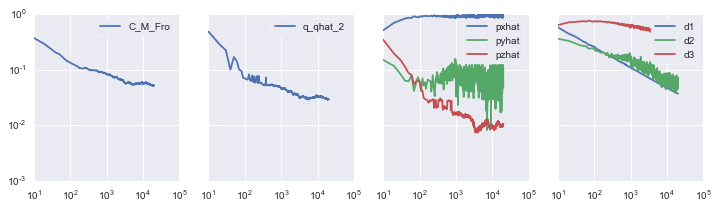

In [29]:
df = pd.read_csv("CorrectlyFadingDelta10x2000.csv", index_col=0)
v = df.groupby("t").mean().reset_index()
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
axs[0].set_ylim(1e-3, 1e0)
axs[0].loglog(v["t"].values, v["C_M_Fro"].values, label="C_M_Fro")
axs[1].loglog(v["t"].values, v["q_qhat_2"].values, label="q_qhat_2")

axs[2].loglog(v["t"].values, v["pxhat"].values, label="pxhat")
axs[2].loglog(v["t"].values, v["pyhat"].values, label="pyhat")
axs[2].loglog(v["t"].values, v["pzhat"].values, label="pzhat")

axs[3].loglog(v["t"].values, v["d1"].values, label="d1")
axs[3].loglog(v["t"].values, v["d2"].values, label="d2")
axs[3].loglog(v["t"].values, v["d3"].values, label="d3")
axs[0].legend(frameon=True)
axs[1].legend(frameon=True)
axs[2].legend(frameon=True)
axs[3].legend(frameon=True)

In [ ]:
def all_rates(C, n, wx, wy, wz):
    px, py, pz = np.diag(C)
    